<a href="https://colab.research.google.com/github/ThucNguyen22/NYC-TTTP/blob/main/NYC_Taxi_Trip_Time_Prediction_ThucNguyen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.



# **Import libraries and read data.**

In [1]:
# import the libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

import time
import datetime as dt
from seaborn import palettes


import warnings
warnings.filterwarnings("ignore")

# We will use haverseine to calculate the distance using the longitudinal and lattitue data.
!pip install haversine
from haversine import haversine

In [3]:
# Mount the drive.
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Load the data.
df = pd.read_csv('/content/drive/MyDrive//NYC.csv')

# Create a copy of data to be on the safer side.
data = df.copy()

# **Data Overview**


## <b> Brief Description of the Data: </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Kaggle. The data was originally published by the NYC Taxi and Limousine Commission (TLC)

### <b>NYC.csv</b> - the training set (contains 1458644 trip records)

In [5]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
data.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [7]:
#Data size.
shape = data.shape
print(f'The dataset contains {shape[0]} rows and {shape[1]} columns.')

The dataset contains 1458644 rows and 11 columns.


# Data Cleaning and Preparation

In [8]:
#There are no null values in this dataset which saves us a step of imputing.
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
#Let see if there are any duplicates values in dataset.

duplicates = data.duplicated().sum()

if duplicates == 0:
  print('No duplicates exist we are good to go.👌')
else:
  print(duplicates,'exist remove them.')

No duplicates exist we are good to go.👌


In [10]:
# Let us now look at the datatypes of all these columns.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


* ***We have id, pickup_datetime, dropoff_datetime, and store_and_fwd_flag of the type object.***
* ***vendor_id, passenger_count, and trip_duration are of type int.***
* ***pickup_longitude, pickup_latitude, dropoff_longitude, and dropoff_latitude are of type float.***

In [11]:
# Get some statiscis.
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


* ***Vendor id has a minimum value of 1 and a maximum value of 2 which makes sense as we saw there are two vendor ids 1 and 2.***
* ***Passenger count has a minimum of 0 which means either it is an error entered or the drivers deliberately entered 0 to complete a target number of rides.***
* ***The minimum trip duration is also quite low. We will come back to this later during Univariate Analysis.***

***Points to be noted:***
* *id can be dropped - as every ride would have different id it would'nt give any useful insight.*
* *pickup_datetime and dropoff_time need to be changed to datetime format - currently they are in string (object) format.*
* *extract data from datetime values.*
* *duration is given in seconds lets convert it into minutes.*
* *store_and_fwd_flag is a categorical variable that needs to be converted.*
* *vendor_id consists of two values 1 and 2.*
* *passenger_count ranges from 0-9, the difference between the 75th percentile and the max value shows the precense of outliers.*
* *trip_duration_minutes also contains outliers.*

## Create Feature

In [12]:
data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime']=pd.to_datetime(data['dropoff_datetime'])

In [13]:
# Retrive day and month data.
data['day'] = data.pickup_datetime.dt.weekday
data['month'] = data.pickup_datetime.dt.month

# Retrive pickup and dropoff hrs.
data['pickup_hour'] = data.pickup_datetime.dt.hour
data['dropoff_hour'] = data.dropoff_datetime.dt.hour

In [14]:
# Since there are total 24 different values in these two columns it would be better to categorize them and get dummies for them.

# Function to convert pickup/dropoff hours to category.
def timezone(x):
  if x>=(0) and x <(5):
    return 'mid_night'
  elif x>=(5) and x <(12):
    return 'morning'
  elif x>=(12) and x <(16):
    return 'afternoon'
  elif x>=(16) and x <(19):
    return 'evening'
  elif x>=(19) and x <(25):
    return 'night'

In [15]:
# Now lets drop pickup_datetime and dropoff_datetime as we have extracted data from it.
data.drop(['pickup_datetime', 'dropoff_datetime'], inplace=True, axis=1)

* *0 - Monday | 1 - Tuesday | 2 - Wednesday | 3 - Thursday | 4 - Friday | 5 - Saturday | 6 - Sunday*
* *pickup_hour and dropoff_hour with an hour of the day in the 24-hour format.*
*pickup_hour and dropoff_hour with an hour of the day in the 24-hour format.
pickup_month and dropoff_month with month number with January=1 and December=12.*

In [16]:
# Convert the data from seconds to mins.
data['trip_duration_minutes']=data['trip_duration']/60

# Drop duration in seconds.
data.drop('trip_duration', inplace=True, axis=1)

In [17]:
# Function to calculate distance using the haversine function as we are provided with gps data.
from geopy.distance import great_circle


def calc_distance(df):
    start_coordinates = (df['pickup_latitude'], df['pickup_longitude'])
    stop_coordinates = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(start_coordinates, stop_coordinates)

In [18]:
# Get distances.
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

In [19]:
data.nunique()

id                       1458644
vendor_id                      2
passenger_count               10
pickup_longitude           23047
pickup_latitude            45245
dropoff_longitude          33821
dropoff_latitude           62519
store_and_fwd_flag             2
day                            7
month                          6
pickup_hour                   24
dropoff_hour                  24
trip_duration_minutes       7417
distance                 1452288
dtype: int64

* ***We see that id has 1458644 unique values which are equal to the number of rows in our dataset.***
* ***There are 2 unique vendor ids.***
* ***There are 9 unique passenger counts.***
* ***There are 2 unique values for store_and_fwd_flag, that we also saw in the description of the variables, which are Y and N.***

In [20]:
# Recheck if formats been changed.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     1458644 non-null  object 
 1   vendor_id              1458644 non-null  int64  
 2   passenger_count        1458644 non-null  int64  
 3   pickup_longitude       1458644 non-null  float64
 4   pickup_latitude        1458644 non-null  float64
 5   dropoff_longitude      1458644 non-null  float64
 6   dropoff_latitude       1458644 non-null  float64
 7   store_and_fwd_flag     1458644 non-null  object 
 8   day                    1458644 non-null  int32  
 9   month                  1458644 non-null  int32  
 10  pickup_hour            1458644 non-null  int32  
 11  dropoff_hour           1458644 non-null  int32  
 12  trip_duration_minutes  1458644 non-null  float64
 13  distance               1458644 non-null  float64
dtypes: float64(6), int

***Now lets bring in the charts and diagrams for better understanding.***  *😊*

# **Exploratory Data Analysis.**

## **Univariate Analysis**

In [21]:
data['trip_duration_minutes'].describe()

count    1.458644e+06
mean     1.599154e+01
std      8.729053e+01
min      1.666667e-02
25%      6.616667e+00
50%      1.103333e+01
75%      1.791667e+01
max      5.877137e+04
Name: trip_duration_minutes, dtype: float64

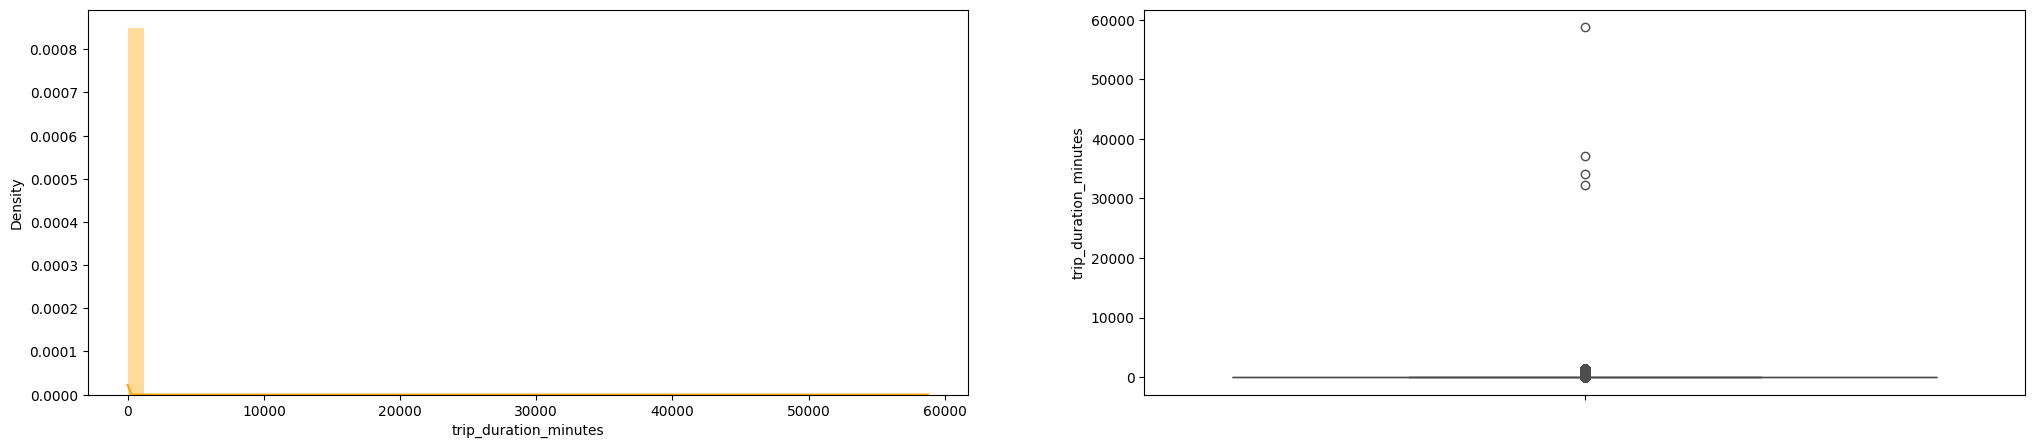

In [22]:
# Check out the trip_duration.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,5))
# plt.figure(figsize=(10,5))
sns.distplot(data['trip_duration_minutes'], color='orange', ax=ax1)
sns.boxplot(data['trip_duration_minutes'], color='orange', ax=ax2)
plt.show()

* ***trip_duration_minutes is positively skewed.***
* ***also it seems there are few extreme values that we will need to check.***

In [23]:
data[data['trip_duration_minutes'] > 10000]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes,distance
355003,id1864733,1,1,-73.789650,40.643559,-73.956810,40.773087,N,1,1,0,11,32328.933333,20.148692
680594,id0369307,1,2,-73.921677,40.735252,-73.984749,40.759979,N,5,2,22,15,34159.633333,5.982495
924150,id1325766,1,1,-73.983788,40.742325,-73.985489,40.727676,N,1,1,6,1,37126.866667,1.635130
978383,id0053347,1,1,-73.783905,40.648632,-73.978271,40.750202,N,5,2,22,18,58771.366667,19.900689


* ***Now that we look at the extreme values these are more than 20 days, which was either due to some technical error or a vaccation was planned.***
* ***Since there are only four values and these could only cause problems for our model lets remove these values.***

In [24]:
# Get rid of the extreme values.
nyc_df = data[data['trip_duration_minutes'] < 10000]

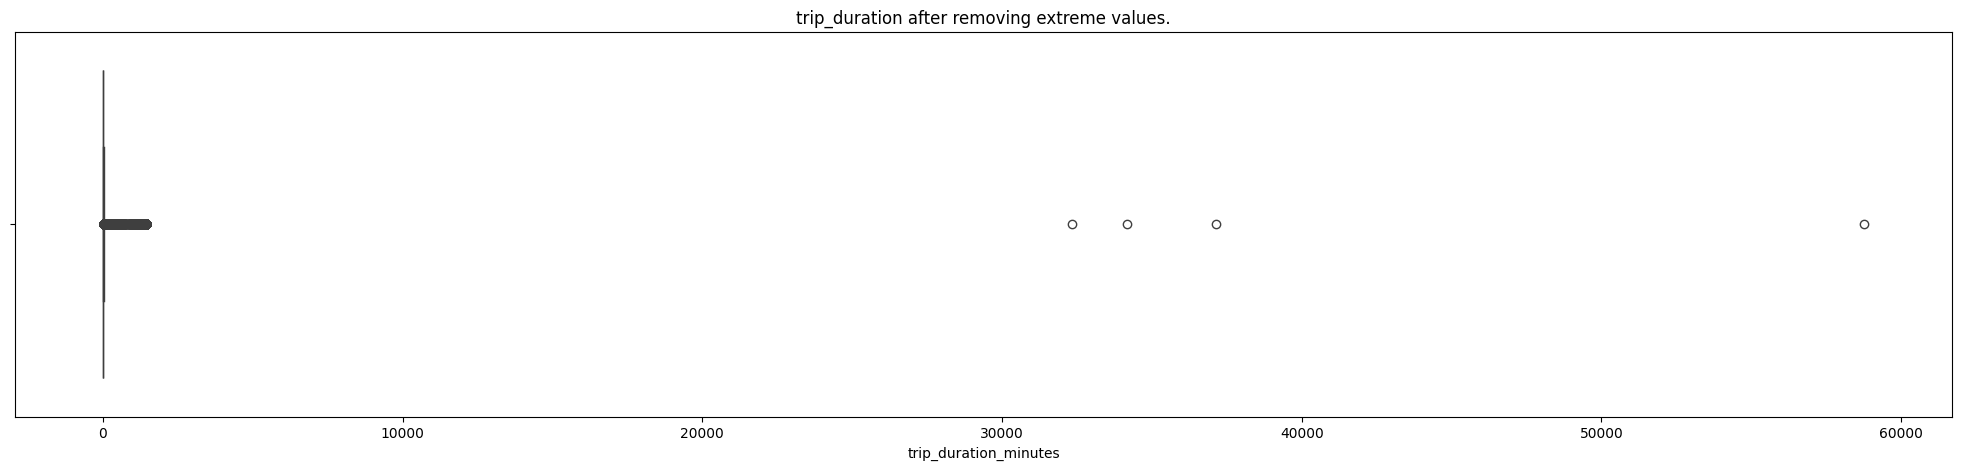

In [25]:
# Now lets check for outliers in the dependent variables.
fig = plt.figure(figsize=(25,5))
sns.boxplot(data['trip_duration_minutes'], orient= 'h')
plt.title('trip_duration after removing extreme values.')
plt.show()

* ***there are few values which maybe outliers, this could be bad for our model.***
* ***lets look into this ahead in our analysis.***

In [26]:
data.head(1)

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes,distance
0,id2875421,2,1,-73.982155,40.767937,-73.96463,40.765602,N,0,3,17,17,7.583333,1.498523


In [27]:
independent_variables = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                         'dropoff_latitude', 'store_and_fwd_flag', 'day', 'month', 'pickup_hour', 'dropoff_hour']

**vendor_id.**

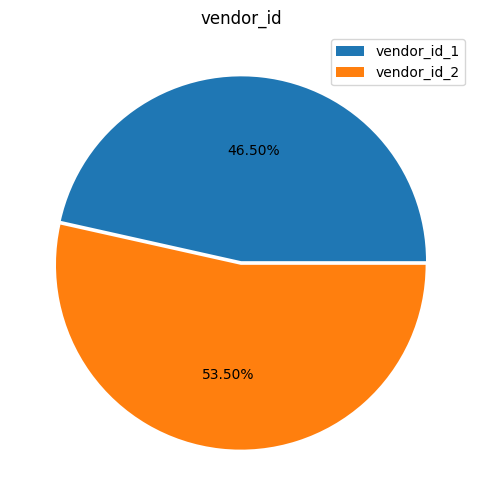

In [28]:
# Calculate the trips done by each vendor.
one = len(data[data['vendor_id'] == 1])
two = len(data[data['vendor_id'] == 2])
v_id = [one, two]
v_name = ['vendor_id_1', 'vendor_id_2']

# Plot it.
fig = plt.figure(figsize=(6,6))
plt.pie(v_id, autopct='%1.2f%%', explode=(0.01,0.01))
plt.title('vendor_id')
plt.legend(labels=v_name)

plt.show()

* ***53.50% of the trips are completed by the vendor 2 and 46.50% of the trips are completed by vendor 1.***
* ***also maximum duration is covered by vendor 2***

.

**passenger_count.**

In [29]:
data['passenger_count'].describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

* ***some values are zero which mean either the trip was cancled or there was an error in the data entry.***
* ***7, 8, 9 are extreme cases considering the capacity of a car, so we will get rid of them.***
* ***most of the trips (75%) contain atmost 1 or 2 passengers.***

**Remove unwanted values from passenger_count.**

In [30]:
# Remove the extreme values from passenger_count.
data = data[data['passenger_count'] <= 6]  # This will remove passenger values with 7,8,9 values.

In [31]:
# Remove values which are zero.
data = data[data.passenger_count != 0]

<Axes: xlabel='passenger_count', ylabel='count'>

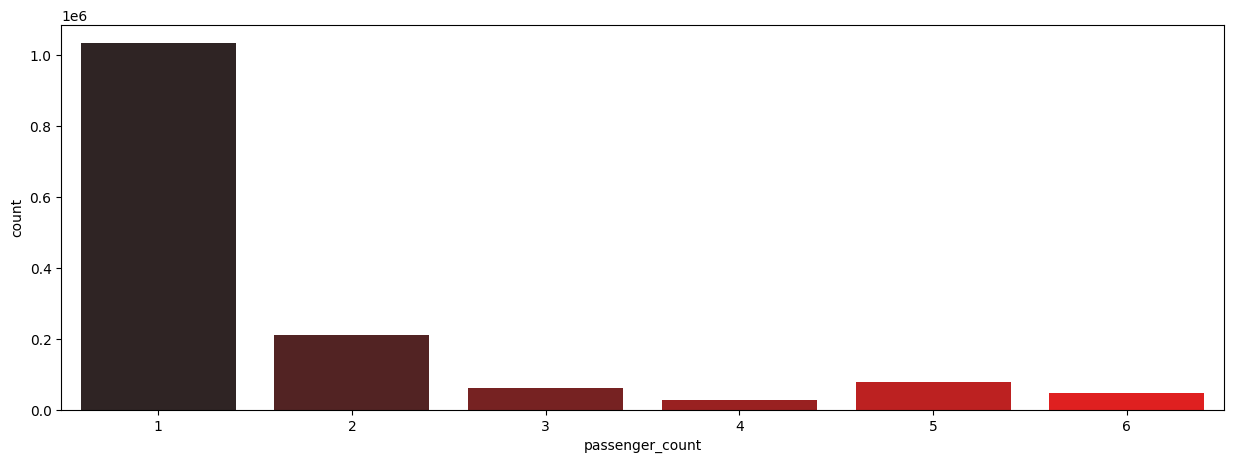

In [32]:
plt.figure(figsize=(15,5))
sns.countplot(data = data, x='passenger_count',palette='dark:red')

***Looks good*** *👍*

Distance.

In [33]:
data['distance'].value_counts()

distance
0.000000    5887
0.000424     101
0.000424      52
0.000424      48
0.000848      37
            ... 
0.434274       1
3.809274       1
0.563330       1
5.925436       1
1.134044       1
Name: count, Length: 1452237, dtype: int64

***We see there are 5887 trips with 0 km distance.***

***The reasons for 0 km distance can be:***

* ***The dropoff location couldn’t be tracked.***
* ***The driver deliberately took this ride to complete a target ride number.***
* ***The passengers canceled the trip.***

**pickup/dropoff latitude and longitude.**

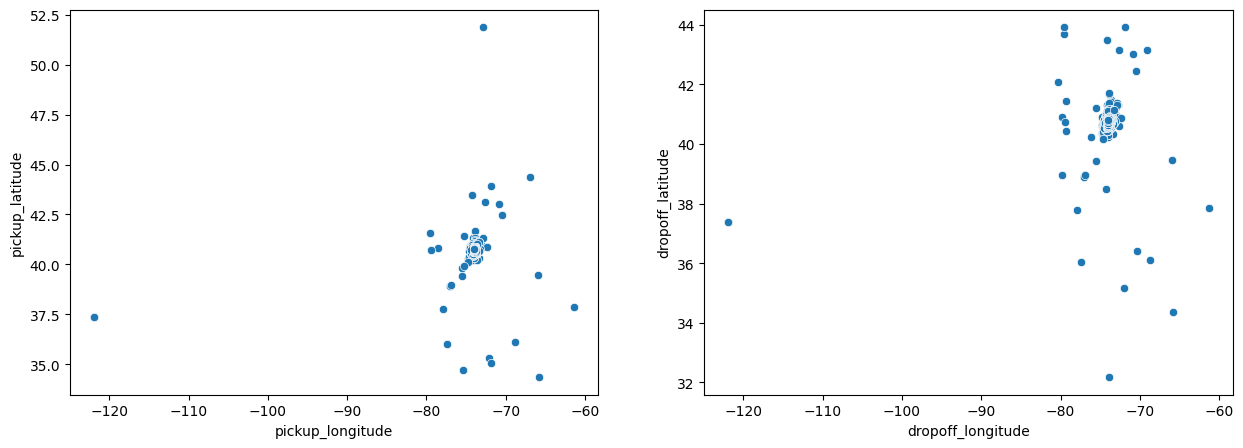

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=data, ax=ax1)
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=data, ax=ax2)
plt.show()

***Lets check whats with those extreme values.***

In [35]:
data[data['pickup_longitude'] < -120]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes,distance
1068810,id3777240,2,2,-121.933235,37.389297,-121.933205,37.389103,N,2,1,18,18,18.416667,0.021800
1184454,id2854272,2,2,-121.933342,37.389381,-121.933304,37.389511,N,4,2,13,13,8.316667,0.014811


In [36]:
data[data['pickup_latitude'] > 50]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes,distance
184925,id2306955,1,1,-72.809669,51.881084,-73.987228,40.750599,N,5,5,18,19,13.2,1240.910391


In [37]:
data[data['dropoff_longitude'] < -120]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes,distance
1068810,id3777240,2,2,-121.933235,37.389297,-121.933205,37.389103,N,2,1,18,18,18.416667,0.021800
1184454,id2854272,2,2,-121.933342,37.389381,-121.933304,37.389511,N,4,2,13,13,8.316667,0.014811


In [38]:
data[data['dropoff_latitude'] < 34]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes,distance
275644,id0978162,1,4,-75.354332,34.712234,-73.834923,32.181141,N,2,2,16,16,14.583333,314.764638


***Lets drop these values.***

In [39]:
data = data[data.id != 'id3777240']
data = data[data.id != 'id2854272']
data = data[data.id != 'id2306955']
data = data[data.id != 'id0978162']

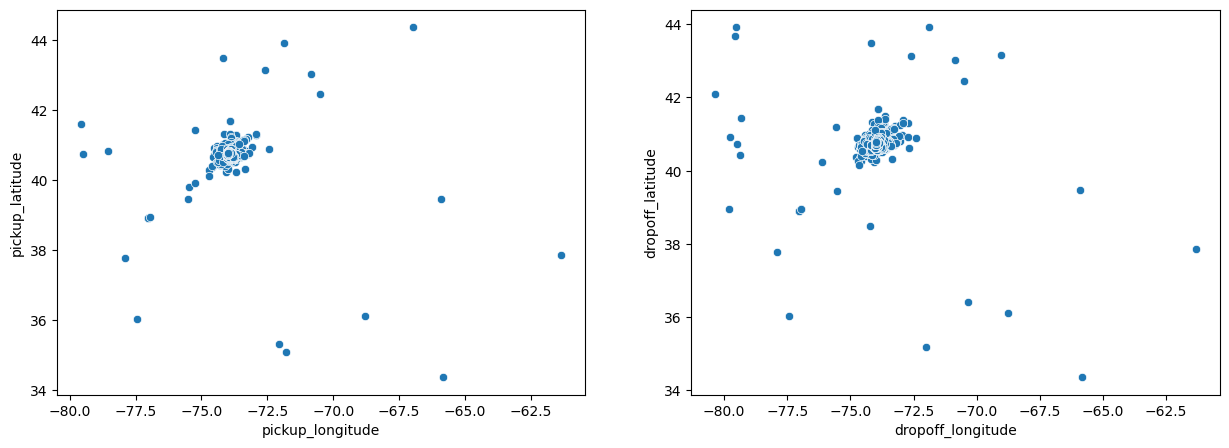

In [40]:
#after drop values
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(x='pickup_longitude', y ='pickup_latitude', data=data ,ax=ax1)
sns.scatterplot(x ='dropoff_longitude', y= 'dropoff_latitude',data=data ,ax=ax2)
plt.show()

***It looks better now.***

**store_and_fwd_flag.**

In [41]:
nyc_df['store_and_fwd_flag'].describe()

count     1458640
unique          2
top             N
freq      1450595
Name: store_and_fwd_flag, dtype: object

In [42]:
nyc_df['store_and_fwd_flag'].value_counts(normalize=True)

store_and_fwd_flag
N    0.994485
Y    0.005515
Name: proportion, dtype: float64

* ***We see there are less than 1% of trips that were stored before forwarding.***
* ***this ia a categorical feature which we will be converting into numeric by getting dummies.***

## **Bivariate  Analysis**

**Trip duration per day/month	and pickup_hour/dropoff_hour**

In [43]:
data.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes,distance
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,0,3,17,17,7.583333,1.498523
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,6,6,0,0,11.050000,1.805510
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,1,1,11,12,35.400000,6.385107
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,2,4,19,19,7.150000,1.485500
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,5,3,13,13,7.250000,1.188590


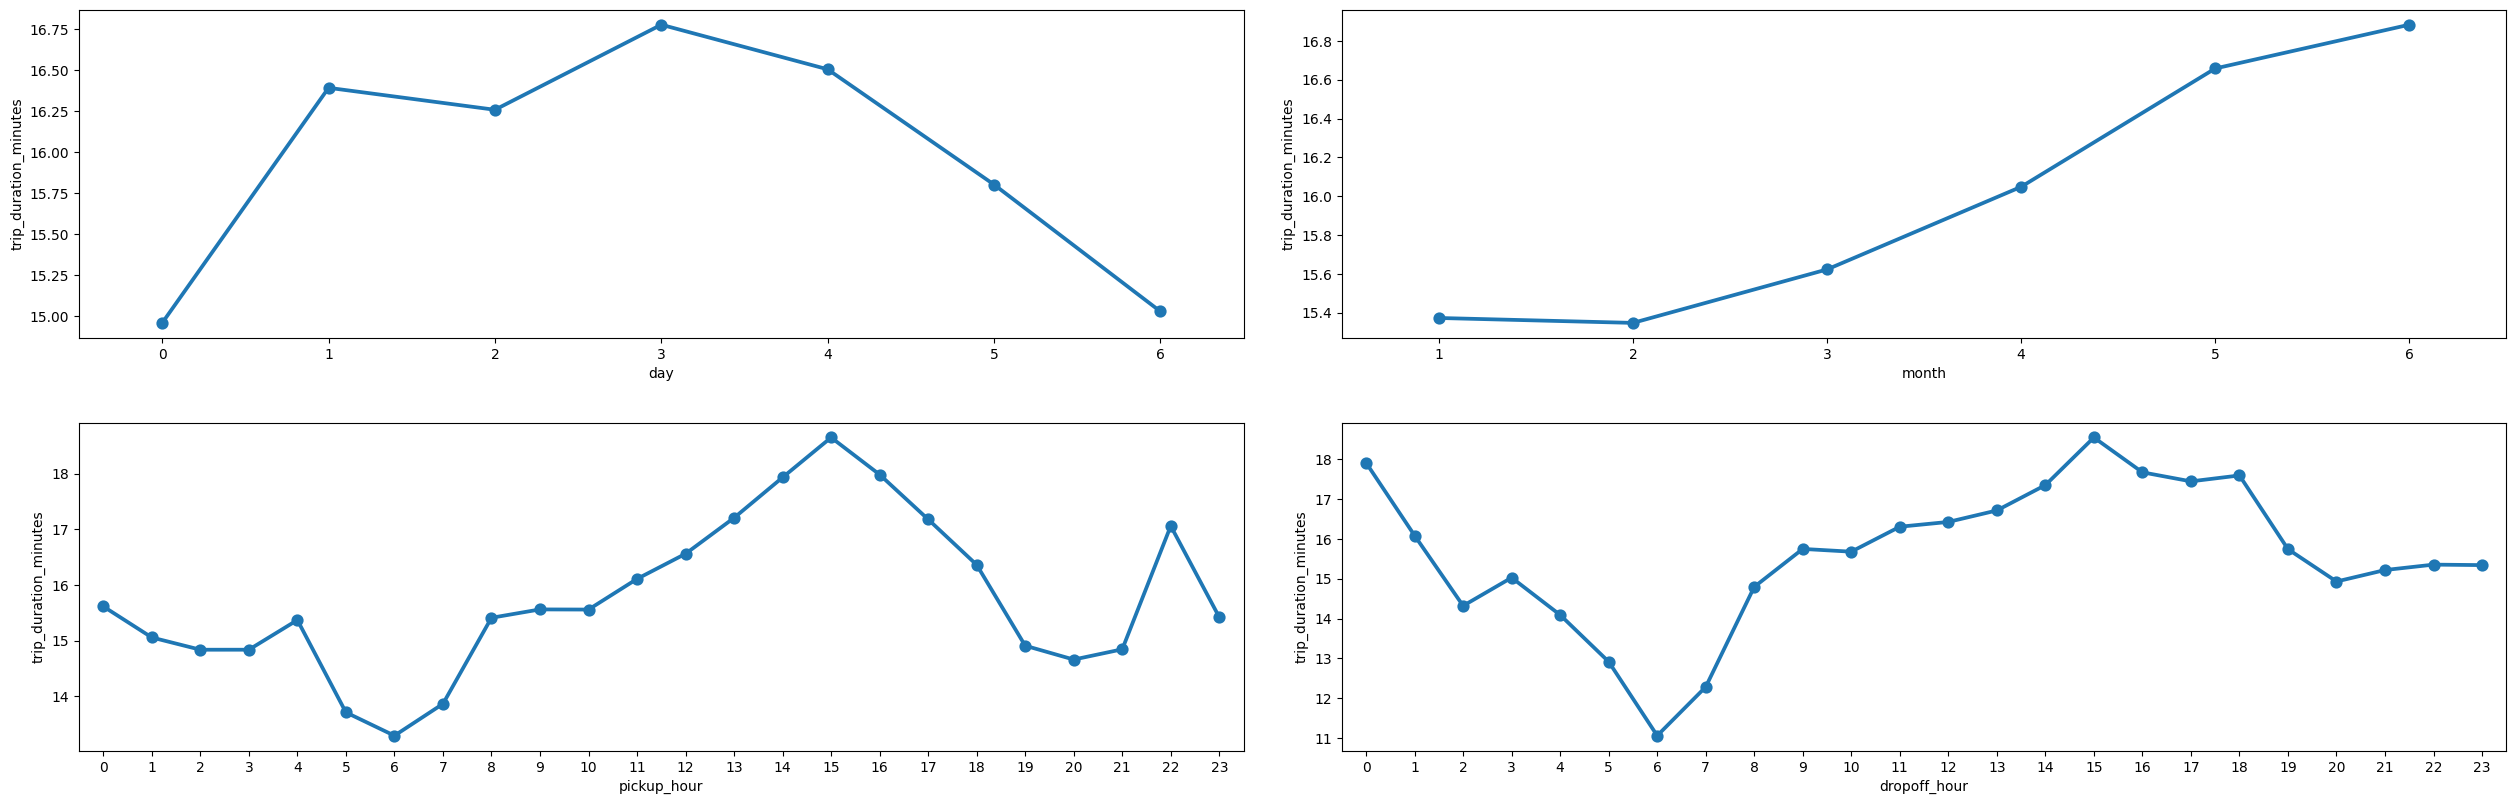

In [44]:
# Now lets get some visuals from the above data.
fig, ax = plt.subplots(2,2, figsize=(25,8))
fig.tight_layout(h_pad=4, w_pad=4)
sns.pointplot(data=data, x='day', y='trip_duration_minutes', ax=ax[0][0], ci=None)
sns.pointplot(data=data, x='month', y='trip_duration_minutes', ax=ax[0][1], ci=None)
sns.pointplot(data=data, x='pickup_hour', y='trip_duration_minutes', ax=ax[1][0], ci=None)
sns.pointplot(data=data, x='dropoff_hour', y='trip_duration_minutes', ax=ax[1][1], ci=None)
plt.show()

* ***trip duration decreases as the weekend approches, it makes sense as most of the people either stay at home or go for vacations.***
* ***trip duration increases after Feburary, this might be due to the people returning after holidays***.
* ***pickup and dropoff hours are almost the same, most of the comute happen from 6am to 7pm after which it gradually decreases.***

*Trip duration is generally longer for trips whose flag was not stored.*

In [47]:
data['passenger_count'].value_counts()

passenger_count
1    1033539
2     210316
5      78088
3      59896
6      48333
4      28403
Name: count, dtype: int64

In [48]:
data_passenger = data[data['passenger_count'] < 1000]

<Axes: xlabel='passenger_count', ylabel='trip_duration_minutes'>

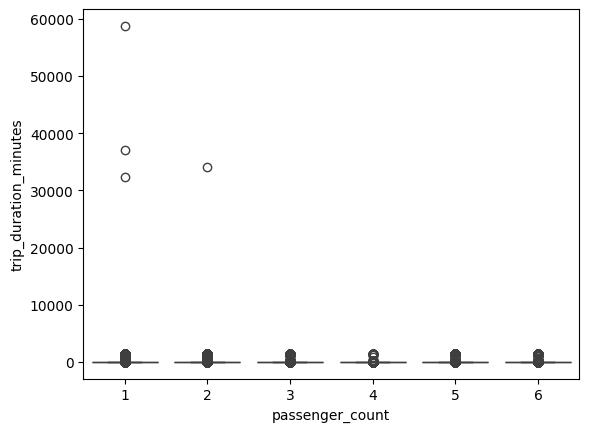

In [50]:
# trip_duration_minutes per passenger
sns.boxplot(data=data_passenger, y='trip_duration_minutes',x='passenger_count')

*There is no visible relation between trip duration and passenger count.*

<Axes: xlabel='vendor_id', ylabel='trip_duration_minutes'>

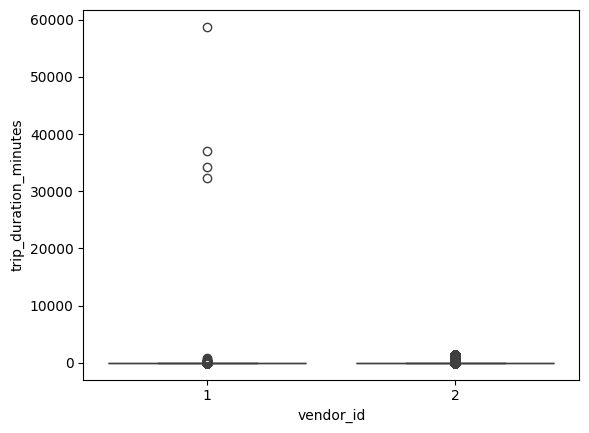

In [52]:
# trip_duration_minutes per passenger
sns.boxplot(data=data, y='trip_duration_minutes',x='vendor_id')

*Vendor id 2 takes longer trips as compared to vendor 1.*


***First lets remove outliers from our dependent variable.***

# **Data Cleaning And Feature Engineering.**

In [53]:
# Create a function that returns upper and lower bounds for removing outliers.
def outlier_treatment(feature):
  sorted(feature)
  Q1,Q3 = np.percentile(feature , [25,75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

In [54]:
# Get upper/lower bounds for trip_duration.
lowerbound,upperbound = outlier_treatment(data['trip_duration_minutes'])
print(lowerbound,upperbound)

data[(data['trip_duration_minutes'] < lowerbound) | (data['trip_duration_minutes'] > upperbound)]

-10.333333333333336 34.866666666666674


,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes,distance
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,1,1,11,12,35.400000,6.385107
16,id3379579,2,1,-73.991165,40.755562,-73.999290,40.725353,N,0,4,17,18,38.600000,3.428091
24,id3321406,2,1,-73.955231,40.777134,-73.788750,40.641472,N,4,6,8,8,41.416667,20.602603
29,id1410897,1,1,-73.982117,40.756351,-73.865692,40.770988,N,2,3,14,14,38.850000,9.939457
33,id0023813,1,1,-73.990311,40.756580,-73.870918,40.773930,N,6,4,14,15,37.816667,10.238399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458571,id1440046,1,2,-73.778946,40.647343,-73.952103,40.781166,N,6,6,22,23,40.900000,20.842687
1458584,id1607338,2,1,-73.786697,40.641628,-73.996880,40.732506,N,1,6,20,21,38.916667,20.400528
1458589,id2071901,1,2,-73.782280,40.644783,-73.904305,40.738285,N,4,6,16,17,34.883333,14.626733
1458600,id0995846,2,2,-73.789543,40.647099,-73.960320,40.798180,N,0,5,17,18,63.683333,22.121091


In [55]:
data.drop(data[ (data['trip_duration_minutes'] > upperbound) | (data['trip_duration_minutes'] < lowerbound) ].index , inplace=True)

**Lets calculate distance travelled using pickup and dropoff data.**

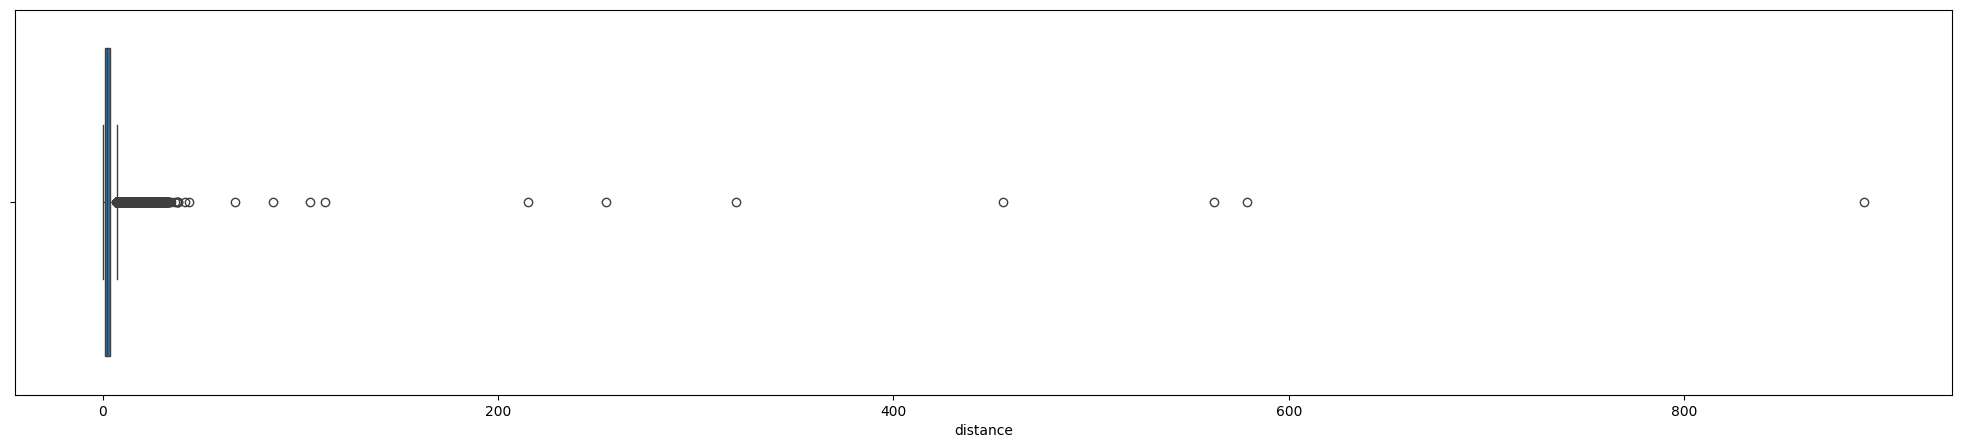

In [56]:
# Get plots.
fig = plt.figure(figsize=(25,5))
sns.boxplot(data['distance'], orient='h')
plt.show()

***There are too many outliers lets remove them.***

In [57]:
# Get upper/lower bounds for trip_duration.
lowerbound,upperbound = outlier_treatment(data['distance'])
print(lowerbound,upperbound)

data[(data['distance'] < lowerbound) | (data['distance'] > upperbound)]

-2.233443060187599 6.9179344413997885


,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes,distance
45,id0718344,2,1,-74.016327,40.704990,-73.982109,40.773750,N,0,6,15,16,24.633333,8.171214
50,id2067879,2,1,-73.996819,40.752861,-73.809006,40.816875,N,1,1,23,23,25.950000,17.340841
54,id0526266,2,1,-73.934883,40.801010,-73.983002,40.722569,N,6,5,9,9,13.650000,9.617850
67,id3913101,1,2,-74.001411,40.761433,-73.924629,40.864029,N,5,6,22,22,16.716667,13.111154
86,id0283075,1,1,-73.782478,40.644646,-73.981125,40.720886,N,2,4,23,0,29.700000,18.773512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458538,id1302341,1,1,-73.973053,40.793495,-73.872581,40.774479,N,0,2,19,19,25.516667,8.719416
1458546,id2085200,1,1,-73.995178,40.749668,-73.960800,40.688099,N,4,3,4,4,29.850000,7.434015
1458547,id2525150,1,1,-73.978241,40.744911,-73.870483,40.773777,N,1,3,12,13,23.150000,9.626801
1458553,id2796154,1,1,-73.985817,40.727772,-74.021095,40.628605,N,3,4,3,3,21.500000,11.421131


In [58]:
data.drop(data[(data['distance'] > upperbound) | (data['distance'] < lowerbound) ].index , inplace=True)

***Lets check the relation between distance and the dependent variable.***

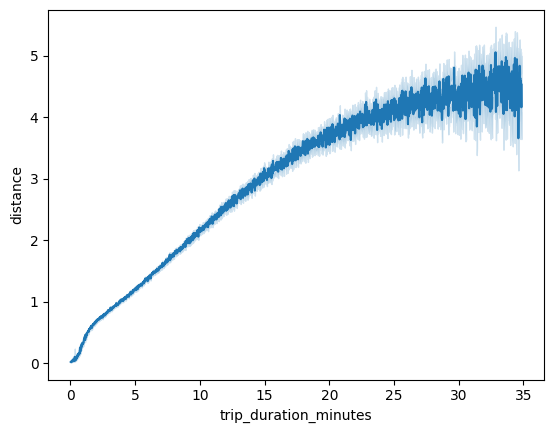

In [59]:
sns.lineplot(x= 'trip_duration_minutes', y= 'distance',data=data)
plt.show()

* ***Distances are the longest around 5 am.***
* ***This can probably point to outstation trips where people start early for the day.***
* ***As we also saw during trip duration per month, similarly trip distance is the lowest in February and the maximum in June.***
* ***Distances are longer on Sundays probably because it’s weekend.***

.

**Get dummies for store_and_fwd_flag, day, month.**

In [60]:
data = pd.get_dummies(data, columns=['store_and_fwd_flag'], drop_first=True)


In [61]:
data = pd.get_dummies(data, columns=['day', 'month'])

.

**Transform pickup/ dropoff hours.**

I have defined a function that lets us determine what time of the day the ride was taken. I have created 4 time zones ‘Morning’ (from 6:00 am to 11:59 pm), ‘Afternoon’ (from 12 noon to 3:59 pm), ‘Evening’ (from 4:00 pm to 9:59 pm), and ‘Late Night’ (from 10:00 pm to 5:59 am)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1276672 entries, 0 to 1458643
Data columns (total 25 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     1276672 non-null  object 
 1   vendor_id              1276672 non-null  int64  
 2   passenger_count        1276672 non-null  int64  
 3   pickup_longitude       1276672 non-null  float64
 4   pickup_latitude        1276672 non-null  float64
 5   dropoff_longitude      1276672 non-null  float64
 6   dropoff_latitude       1276672 non-null  float64
 7   pickup_hour            1276672 non-null  int32  
 8   dropoff_hour           1276672 non-null  int32  
 9   trip_duration_minutes  1276672 non-null  float64
 10  distance               1276672 non-null  float64
 11  store_and_fwd_flag_Y   1276672 non-null  bool   
 12  day_0                  1276672 non-null  bool   
 13  day_1                  1276672 non-null  bool   
 14  day_2                  

In [63]:
# Apply the above function.
data['pickup_time'] = data['pickup_hour'].apply(lambda x :timezone(x) )
data['dropoff_time'] = data['dropoff_hour'].apply(lambda x :timezone(x) )

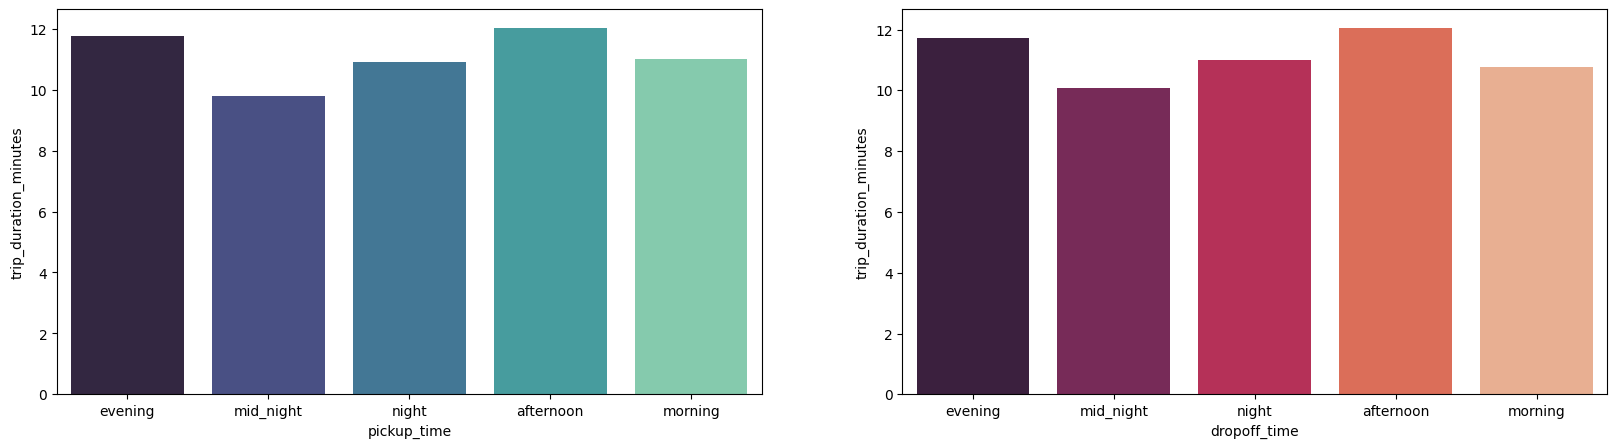

In [64]:
# Plot it.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
sns.barplot(data=data, x='pickup_time', y='trip_duration_minutes', ax=ax1,ci=None,palette='mako')
sns.barplot(data=data, x='dropoff_time', y='trip_duration_minutes', ax=ax2,ci=None,palette='rocket')
plt.show()

* ***most of the pickups and dropoffs happen in the evenings and afternoons, which makes sense as most people comute during these timimgs.***

In [65]:
# Now lets get dummies for these variables.
data = pd.get_dummies(data, columns=['pickup_time', 'dropoff_time'])

***Now than we are done with the cleaning as well as the feature engineering of our data lets do some feature selection before proceeding with the model building.***

# **Data preparation.**

In [66]:
# Lets drop id before going further as its not useful.
data.drop('id', inplace=True, axis=1)

***Split the data first.***

In [67]:
# Get X and y values.
X = data.drop('trip_duration_minutes', axis=1)

y = data['trip_duration_minutes']

In [68]:
# Train Test Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state =5)

In [69]:
# scale the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Correlation between variables.**

***Correlation of features with the dependent variable.***

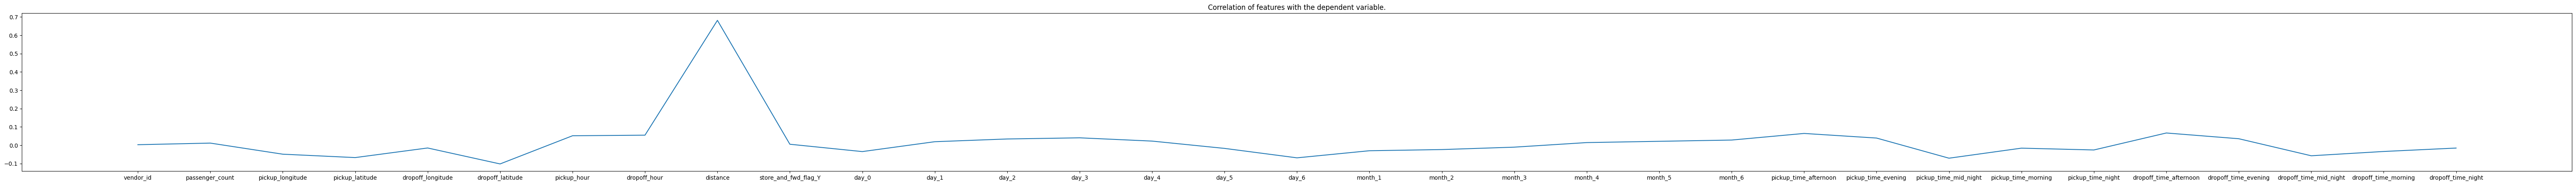

In [70]:
corr_data = X.corrwith(y)
plt.figure(figsize=(80,5))
plt.plot(corr_data)
plt.title('Correlation of features with the dependent variable.')
plt.show()

***Check for multicollinearity among the variables.***

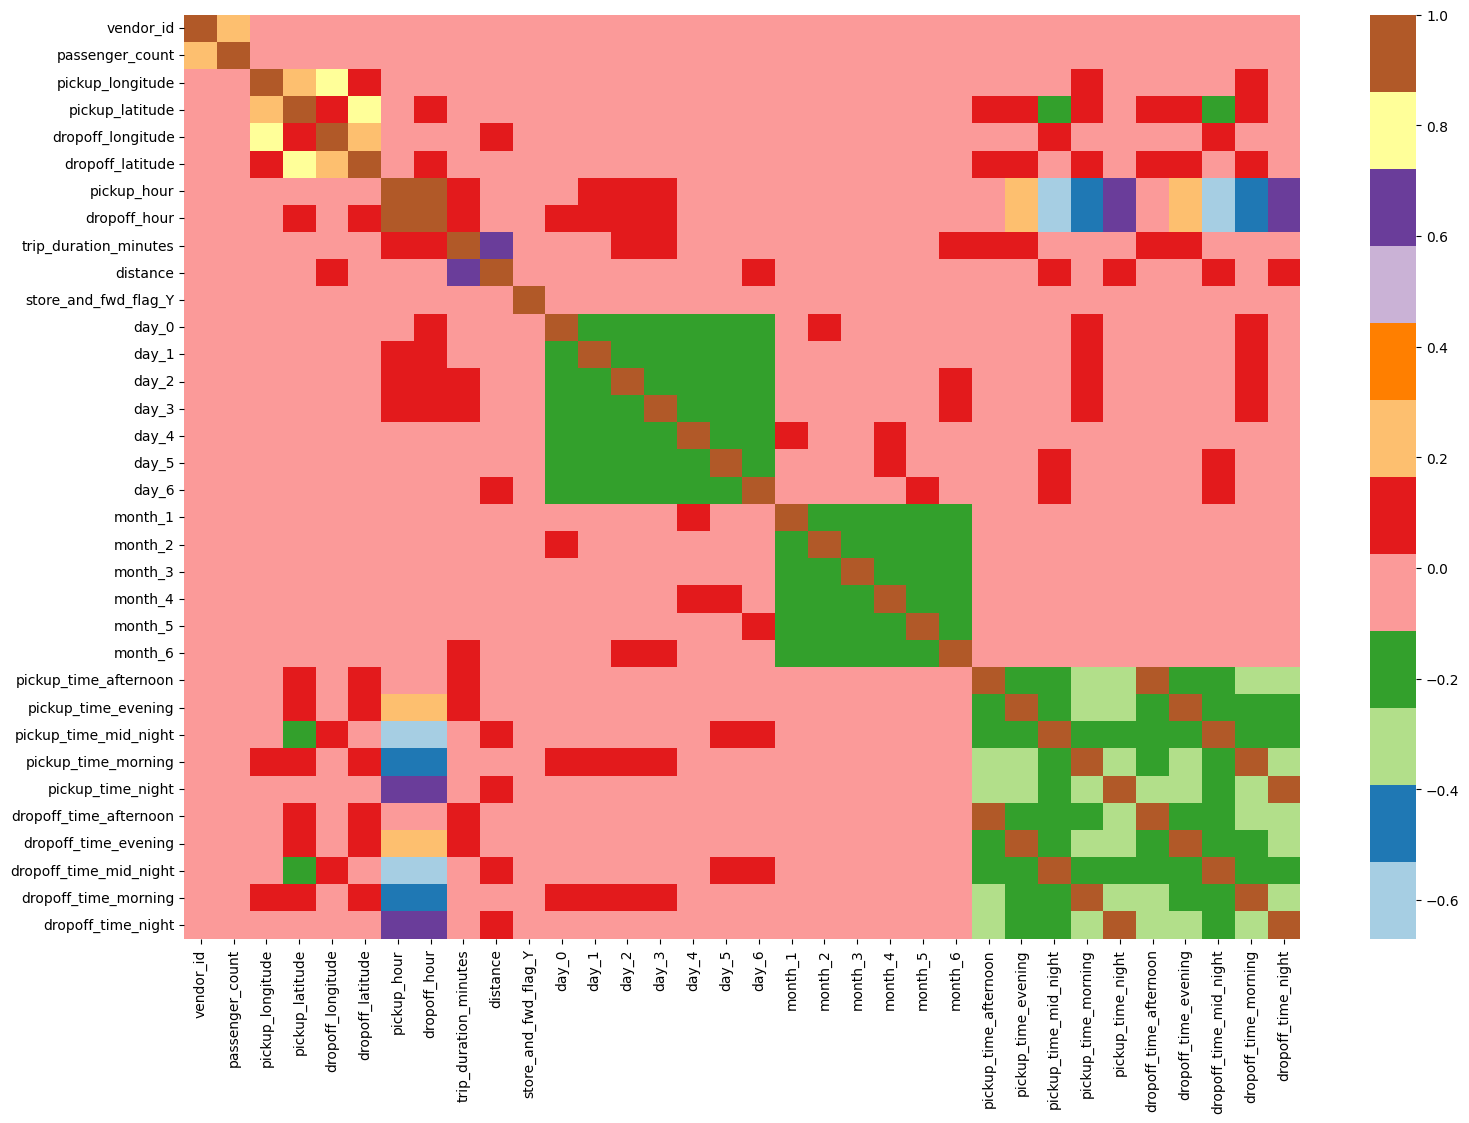

In [71]:
# Multicollinearity.
fig = plt.figure(figsize=(18,12))
sns.heatmap(data.corr(), cmap='Paired')
plt.show()

***Now that we have completed preparing our data lets build few models using it.***

# **Select Model:**

**Models we will be building:**
* **Linear Regression**
* **Decision Tree Regressorr**
* **XG Boost Regressor**
* **Hist Gradient Boosting Regressor**



In [72]:
# Defining the models to be used.
models = [['Linear Regression', LinearRegression()],
          ['Decision Tree Regressor', DecisionTreeRegressor()],
          ['XG Boost Regressor', xgb.XGBRegressor()],
          ['Hist Gradient Boosting Regressor', HistGradientBoostingRegressor()],
          ]

In [73]:
# Creating a function to train and test models.
model_data = []
for name,current_model in models:
  current_model_data = {}
  current_model.random_state = 78
  current_model_data["Name"] = name
  start = time.time()
  current_model.fit(X_train,y_train)
  end = time.time()
  current_model_data["Train_Time"] = end - start
  current_model_data["Train_R2_Score"] = r2_score(y_train,current_model.predict(X_train))
  current_model_data["Test_R2_Score"] = r2_score(y_test,current_model.predict(X_test))
  current_model_data["Test_RMSE_Score"] = np.sqrt(mean_squared_error(y_test,current_model.predict(X_test)))
  model_data.append(current_model_data)

In [74]:
results_df = df = pd.DataFrame(model_data)
results_df

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,Linear Regression,3.801100,0.527757,0.528720,4.568898
1,Decision Tree Regressor,30.290925,0.999988,0.422492,5.057680
2,XG Boost Regressor,15.920650,0.725269,0.718295,3.532399
3,Hist Gradient Boosting Regressor,28.732723,0.687187,0.686527,3.726254


**Hist Gradient Boosting Regressor performs the best with a Test R2 as 0.686527 and Test_RMSE of 3.726254.**

# **Hyperparameter Tuning:**

**We will tune the parameters of Hist Gradient Boosting Regressor for better results.**

In [75]:
# Maximum depth of trees
max_depth = [6,8,10]

# Learning Rate
learning_rate = [0.2,0.4,0.6]

# Minimum sample leafs.
min_samples_leaf = [50,60]

# Maximum itteration.
max_iter = [400,500]

# Hyperparameter Dict
param_dict = {
              'max_depth' : max_depth,
              'learning_rate' : learning_rate,
              'min_samples_leaf' : min_samples_leaf,
              'max_iter': max_iter
}

In [76]:
# Define model.
# min_samples_leaf = 60, max_iter = 500, learning_rate = 0.2
hbg_reg = HistGradientBoostingRegressor()

# Grid search
hbg_grid = GridSearchCV(estimator=hbg_reg,
                       param_grid = param_dict,
                       cv = 5, verbose=2, scoring='r2')

hbg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END learning_rate=0.2, max_depth=6, max_iter=400, min_samples_leaf=50; total time= 1.1min
[CV] END learning_rate=0.2, max_depth=6, max_iter=400, min_samples_leaf=50; total time= 1.2min
[CV] END learning_rate=0.2, max_depth=6, max_iter=400, min_samples_leaf=50; total time= 1.3min
[CV] END learning_rate=0.2, max_depth=6, max_iter=400, min_samples_leaf=50; total time= 1.1min
[CV] END learning_rate=0.2, max_depth=6, max_iter=400, min_samples_leaf=50; total time= 1.1min
[CV] END learning_rate=0.2, max_depth=6, max_iter=400, min_samples_leaf=60; total time= 1.1min
[CV] END learning_rate=0.2, max_depth=6, max_iter=400, min_samples_leaf=60; total time= 1.2min
[CV] END learning_rate=0.2, max_depth=6, max_iter=400, min_samples_leaf=60; total time= 1.1min
[CV] END learning_rate=0.2, max_depth=6, max_iter=400, min_samples_leaf=60; total time= 1.1min
[CV] END learning_rate=0.2, max_depth=6, max_iter=400, min_samples_leaf=60; total t

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(),
             param_grid={'learning_rate': [0.2, 0.4, 0.6],
                         'max_depth': [6, 8, 10], 'max_iter': [400, 500],
                         'min_samples_leaf': [50, 60]},
             scoring='r2', verbose=2)

In [77]:
hbg_grid.best_params_

{'learning_rate': 0.4, 'max_depth': 8, 'max_iter': 500, 'min_samples_leaf': 60}

In [78]:
hbg_grid.best_estimator_

HistGradientBoostingRegressor(learning_rate=0.4, max_depth=8, max_iter=500,
                              min_samples_leaf=60)

In [79]:
hgb_optimal_model = hbg_grid.best_estimator_

In [80]:
# Making predictions on train and test data
train_class_preds = hgb_optimal_model.predict(X_train)
test_class_preds = hgb_optimal_model.predict(X_test)

In [81]:
#Train set metrics
hgb_MSE_train  = mean_squared_error((y_train), (train_class_preds))
print("MSE :" , hgb_MSE_train)

hgb_RMSE_train = np.sqrt(hgb_MSE_train)

print("RMSE :" ,hgb_RMSE_train)

hgb_r2_train = r2_score((y_train), (train_class_preds))
print("R2 :" ,hgb_r2_train)
hgb_ar2_train = 1-(1-r2_score((y_train), (train_class_preds)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Adjusted R2 : ",hgb_ar2_train)

MSE : 10.562442412702941
RMSE : 3.249991140403761
R2 : 0.7599295920651776
Adjusted R2 :  0.7599218349906739


In [82]:
#Test set metrics
hgb_MSE_test  = mean_squared_error((y_test), (test_class_preds))
print("MSE :" , hgb_MSE_test)

hgb_RMSE_test = np.sqrt(hgb_MSE_test)

print("RMSE :" ,hgb_RMSE_test)

hgb_r2_test = r2_score((y_test), (test_class_preds))
print("R2 :" ,hgb_r2_test)
hgb_ar2_test = 1-(1-r2_score((y_test), (test_class_preds)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",hgb_ar2_test)

MSE : 11.371758163658223
RMSE : 3.3722037547660464
R2 : 0.7432660336145174
Adjusted R2 :  0.7432328483904458


**We can observe improvement in the R2 and RMSE after hyperparameter tuning.**

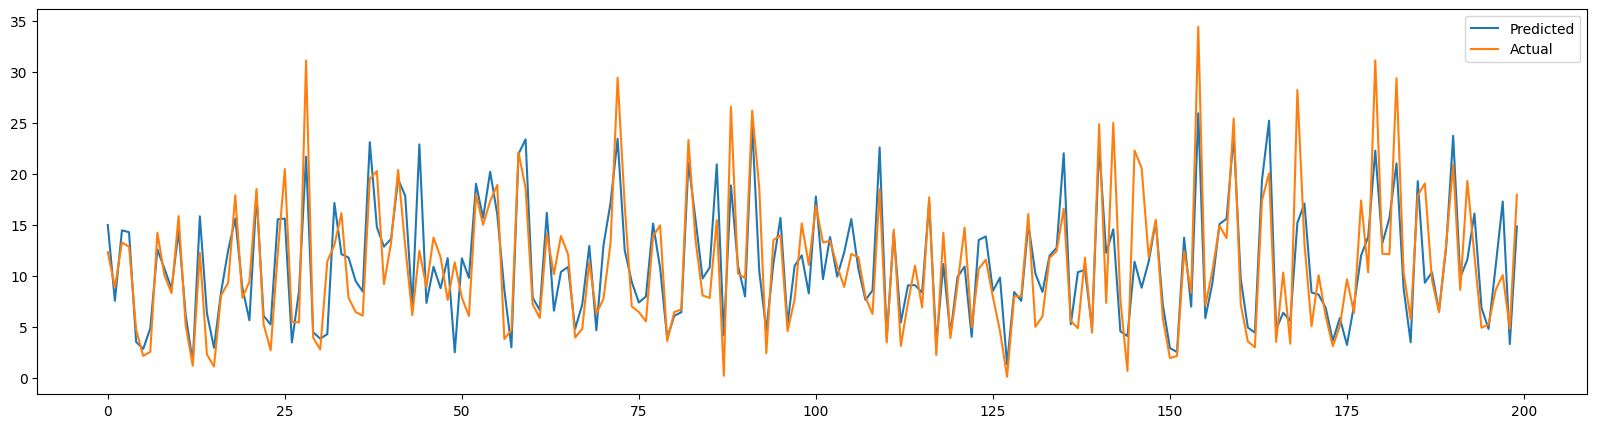

In [83]:
plt.figure(figsize=(20,5))
plt.plot((test_class_preds)[:200])
plt.plot(np.array(y_test)[:200])
plt.legend(["Predicted","Actual"])
plt.show()

* **Since the data is very large we will consider the first 200 values to compare the actual and predicted trip_durations.**
* **As we can see the model has done a pretty good job in predicting the durations.**
* **Hence it would be safe to say that Hist Gradient Boosting Regressor can be used for future predictions.**


# **Conclusions:**
* **Distance calculated using the haversine function plays an important role in predicting the trip durations.**

* **Rest of the features showed moderate to very little linear correlation with the dependent variable.**

* **The best algorithm in this case is Hist Gradient Boosting Regressor.**

* **The untuned model was able to explain 68% of the variance on the test set, while the tuned model explained 74% of variance on the test set which is a good improvement**.

* **The least RMSE on test set by the Hist Gradient Boosting Regressor was 3.249991 which is comparatively lower when compared with rest of the models.**